In [85]:
import numpy as np
import pandas as pd

In [86]:
import os
for dirname, _, filenames in os.walk('/Users/coco/Desktop/專案/titanic/raw'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/Users/coco/Desktop/專案/titanic/raw/test.csv
/Users/coco/Desktop/專案/titanic/raw/train.csv
/Users/coco/Desktop/專案/titanic/raw/gender_submission.csv


In [87]:
train_data = pd.read_csv("/Users/coco/Desktop/專案/titanic/raw/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [88]:
test_data = pd.read_csv("/Users/coco/Desktop/專案/titanic/raw/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [89]:
women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

% of women who survived: 0.7420382165605095


In [90]:
men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

% of men who survived: 0.18890814558058924


In [91]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# 填補 Age 和 Embarked 欄位的缺失值
train_data = train_data.fillna({'Age': train_data['Age'].median(), 'Embarked': 'S'})
test_data = test_data.fillna({'Age': test_data['Age'].median(), 'Embarked': 'S'})

# 生成 FamilySize 特徵
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch'] + 1

# 從 Name 提取 Title 特徵
train_data['Title'] = train_data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
test_data['Title'] = test_data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

# One-hot Encoding
# 使用 drop_first=True 參數是為了避免虛擬變數陷阱（dummy variable trap），即避免生成過多的共線性變數。
if 'Sex' in train_data.columns and 'Embarked' in train_data.columns:
    train_data = pd.get_dummies(train_data, columns=["Sex", "Embarked", "Title"], drop_first=True)
if 'Sex' in test_data.columns and 'Embarked' in test_data.columns:
    test_data = pd.get_dummies(test_data, columns=["Sex", "Embarked", "Title"], drop_first=True)

# 對齊訓練集和測試集的欄位
train_data, test_data = train_data.align(test_data, join='left', axis=1, fill_value=0)

# 選擇特徵 數值特徵（Pclass, SibSp, Parch, FamilySize, Fare）和類別變數（Sex, Embarked, Title）
features = ["Pclass", "SibSp", "Parch", "FamilySize", "Fare"] + [col for col in train_data.columns if "Sex_" in col or "Embarked_" in col or "Title_" in col]
X = train_data[features]
y = train_data["Survived"]
X_test = test_data[features]

# 設置隨機森林模型
rf_model = RandomForestClassifier(random_state=1)

# 超參數範圍設置
param_grid = {
    'n_estimators': [100, 150, 200],  # 樹的數量
    'max_depth': [3, 5, 7],  # 樹的深度
    'min_samples_split': [2, 5, 10],  # 最小分裂樣本數
    'min_samples_leaf': [1, 2, 4],  # 最小葉節點樣本數
    'max_features': ['sqrt', 'log2', None]  # 每棵樹選擇的特徵數量
}

# 執行網格搜尋
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X, y)

# 輸出最佳參數和最佳分數
print("最佳參數：", grid_search.best_params_)
print("最佳交叉驗證分數：", grid_search.best_score_)

# 使用最佳參數訓練模型
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X, y)

# 預測
predictions = best_rf_model.predict(X_test)

# 生成提交文件
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
最佳參數： {'max_depth': 7, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 150}
最佳交叉驗證分數： 0.8383842822170611
Your submission was successfully saved!


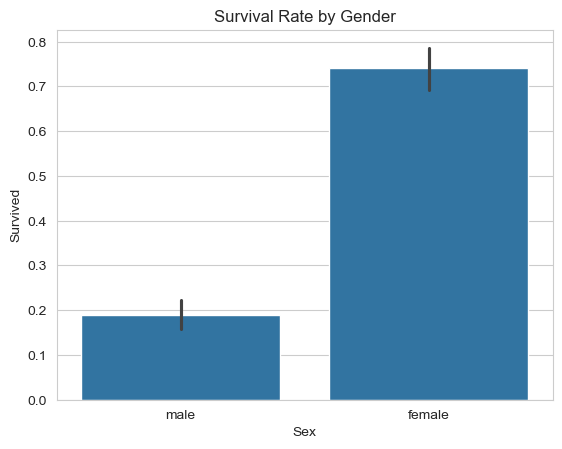

In [92]:
# Map one-hot encoded columns back to a single 'Sex' column for visualization
train_data['Sex'] = train_data[['Sex_male']].apply(lambda x: 'male' if x['Sex_male'] == 1 else 'female', axis=1)

sns.barplot(x="Sex", y="Survived", data=train_data)
plt.title("Survival Rate by Gender")
plt.show()

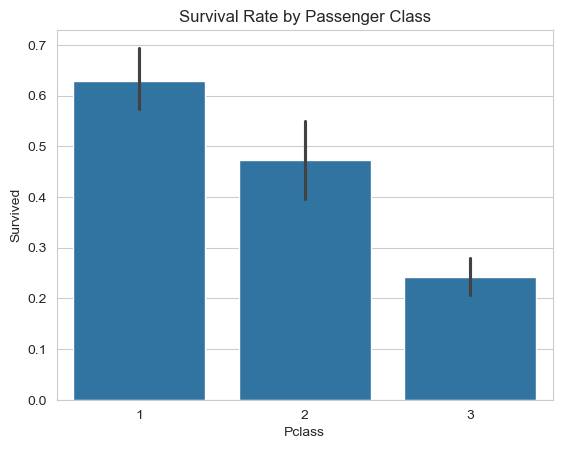

In [93]:
sns.barplot(x="Pclass", y="Survived", data=train_data)
plt.title("Survival Rate by Passenger Class")
plt.show()

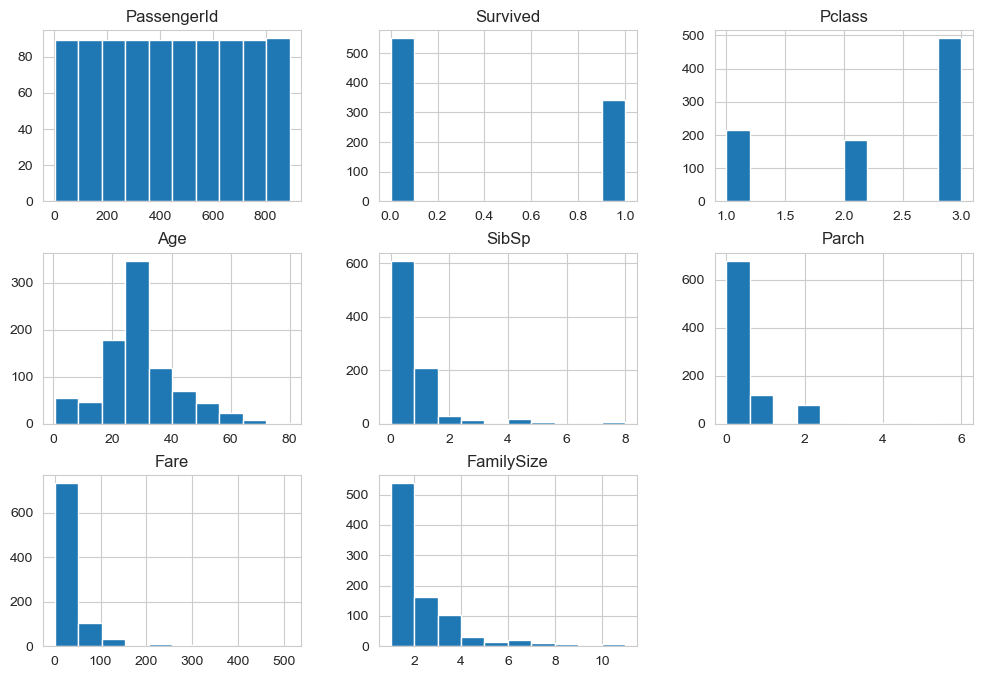

In [94]:
train_data.hist(figsize=(12, 8))
plt.show()

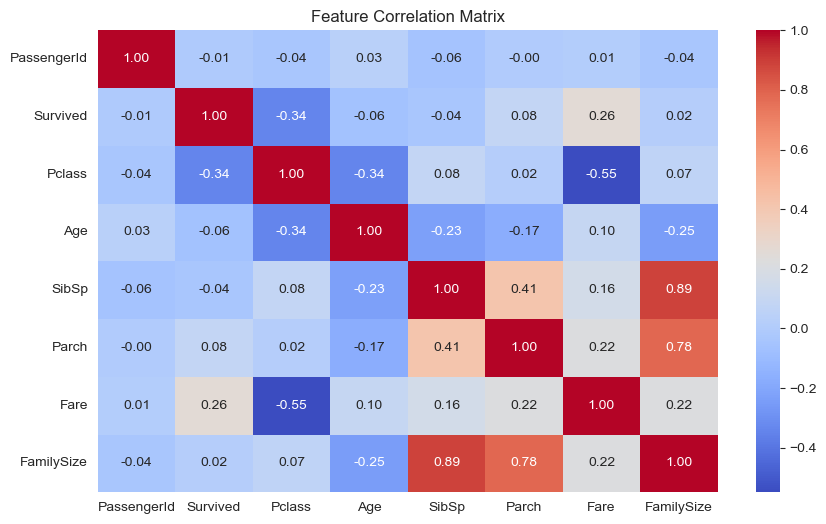

In [95]:
import numpy as np
import seaborn as sns

# Select only numeric columns for correlation calculation
numeric_train_data = train_data.select_dtypes(include=[np.number])
corr = numeric_train_data.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

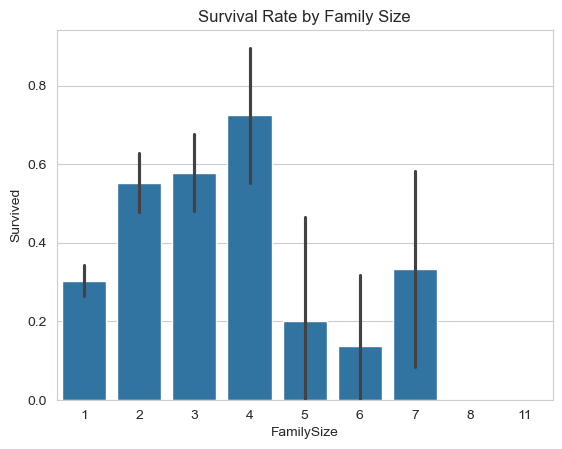

In [96]:
# 特徵工程視覺化
sns.barplot(x="FamilySize", y="Survived", data=train_data)
plt.title("Survival Rate by Family Size")
plt.show()

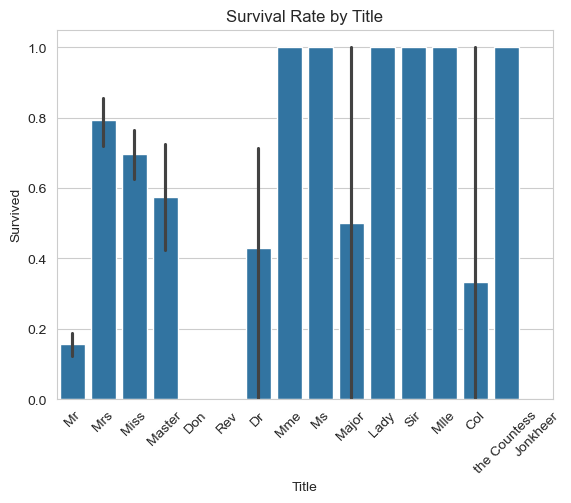

In [97]:
# Map one-hot encoded 'Title' columns back to a single 'Title' column for visualization
title_columns = [col for col in train_data.columns if "Title_" in col]
train_data['Title'] = train_data[title_columns].idxmax(axis=1).str.replace("Title_", "")

sns.barplot(x="Title", y="Survived", data=train_data)
plt.xticks(rotation=45)
plt.title("Survival Rate by Title")
plt.show()

/var/folders/jq/vk8m9frx12j5y9kdyj68nqm40000gn/T/ipykernel_36622/1609771021.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracy, palette="Blues")


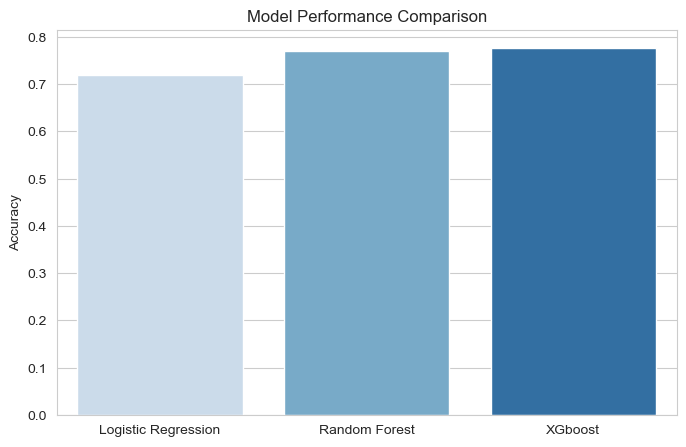

In [98]:
# 模型訓練及超參數調整視覺化
models = ["Logistic Regression", "Random Forest", "XGboost"]
accuracy = [0.72, 0.77, 0.776]

plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=accuracy, palette="Blues")
plt.title("Model Performance Comparison")
plt.ylabel("Accuracy")
plt.show()

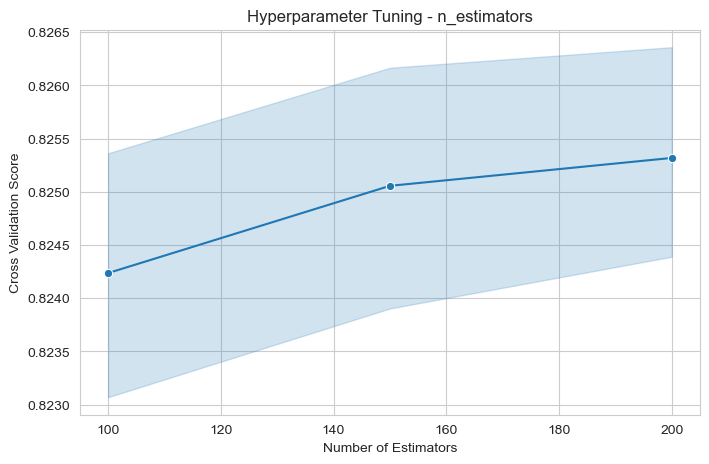

In [99]:
results = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(8, 5))
sns.lineplot(x=results["param_n_estimators"], y=results["mean_test_score"], marker="o")
plt.xlabel("Number of Estimators")
plt.ylabel("Cross Validation Score")
plt.title("Hyperparameter Tuning - n_estimators")
plt.show()

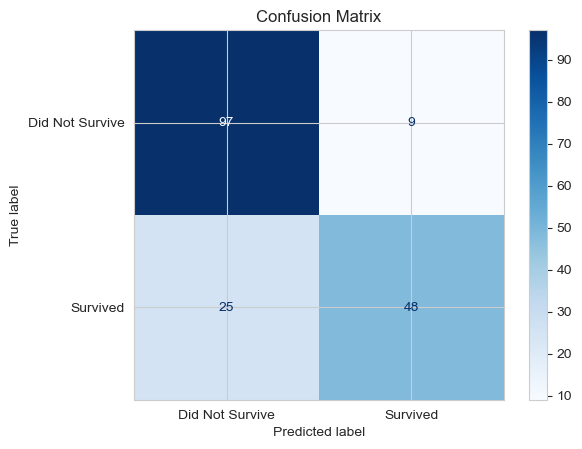

In [100]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test_split, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Train the model on the training set
best_rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf_model.predict(X_test_split)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Did Not Survive", "Survived"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

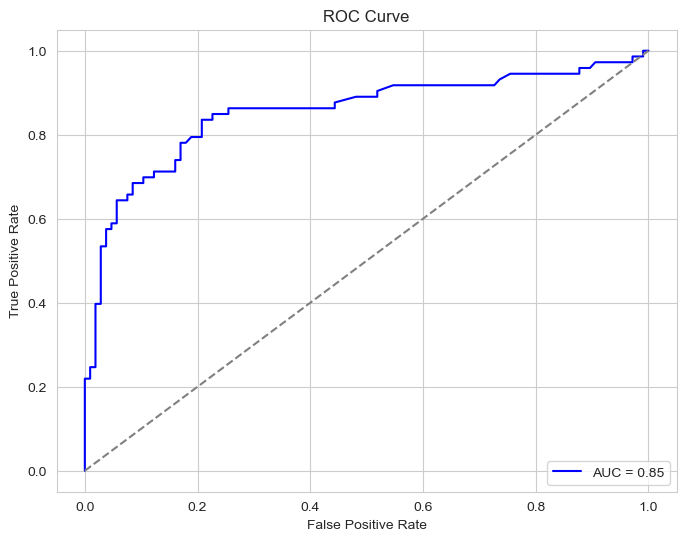

In [101]:
from sklearn.metrics import roc_curve, auc

# Compute predicted probabilities
y_pred_proba = best_rf_model.predict_proba(X_test_split)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

/var/folders/jq/vk8m9frx12j5y9kdyj68nqm40000gn/T/ipykernel_36622/2609021490.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Sex", y="Survived", data=train_data, ax=axes[0], palette="Blues")
/var/folders/jq/vk8m9frx12j5y9kdyj68nqm40000gn/T/ipykernel_36622/2609021490.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Pclass", y="Survived", data=train_data, ax=axes[1], palette="Greens")


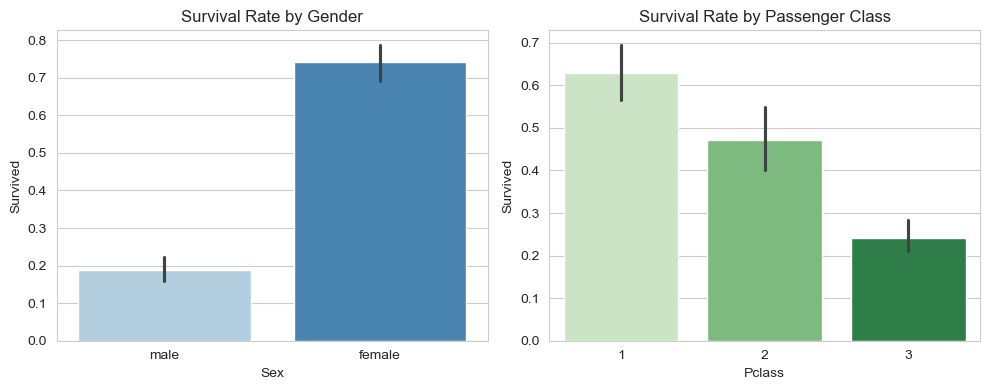

In [103]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 設定 Seaborn 樣式
sns.set_style("whitegrid")

# 建立圖表
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# 性別 vs 生存率
sns.barplot(x="Sex", y="Survived", data=train_data, ax=axes[0], palette="Blues")
axes[0].set_title("Survival Rate by Gender")

# 艙等 vs 生存率
sns.barplot(x="Pclass", y="Survived", data=train_data, ax=axes[1], palette="Greens")
axes[1].set_title("Survival Rate by Passenger Class")

# 調整佈局
plt.tight_layout()
plt.savefig("survival_rate_eda.png", dpi=150)  # 儲存圖片
plt.show()

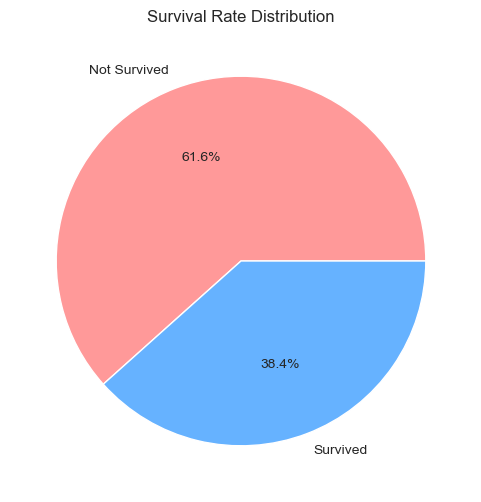

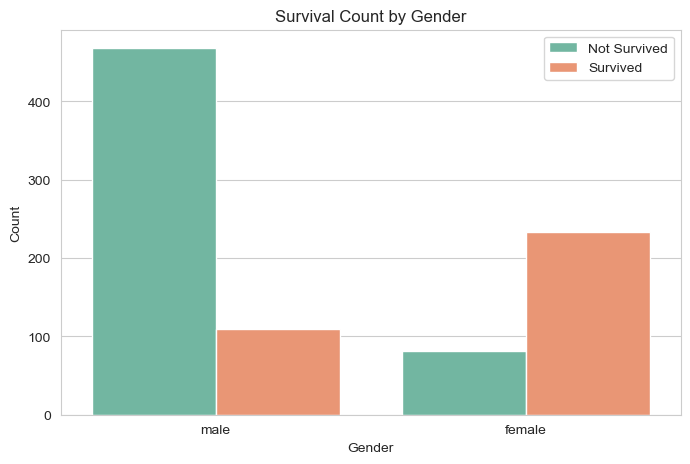

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 假設 train_data 已準備好
# 生存率餅圖
plt.figure(figsize=(6, 6))
train_data['Survived'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#FF9999', '#66B2FF'], labels=['Not Survived', 'Survived'])
plt.title('Survival Rate Distribution')
plt.ylabel('')
plt.savefig('survival_pie.png')
plt.show()

# 性別分佈柱狀圖
plt.figure(figsize=(8, 5))
sns.countplot(x='Sex', hue='Survived', data=train_data, palette='Set2')
plt.title('Survival Count by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(labels=['Not Survived', 'Survived'])
plt.savefig('gender_survival_bar.png')
plt.show()

/var/folders/jq/vk8m9frx12j5y9kdyj68nqm40000gn/T/ipykernel_36622/3838431097.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Survived', y='FamilySize', data=train_data, palette='Pastel1')


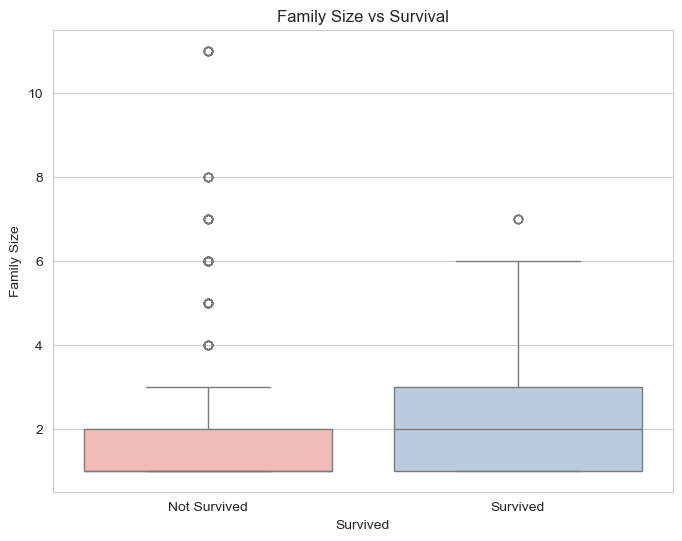

In [136]:
# Age 填補前後對比直方圖
plt.figure(figsize=(10, 6))
sns.histplot(train_data['Age'].dropna(), bins=30, color='blue', alpha=0.5, label='Before Filling')
sns.histplot(train_data['Age'].fillna(train_data['Age'].median()), bins=30, color='orange', alpha=0.5, label='After Filling')
plt.title('Age Distribution Before and After Filling')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('age_distribution.png')
plt.close()

# FamilySize 與生存率的箱形圖
plt.figure(figsize=(8, 6))
sns.boxplot(x='Survived', y='FamilySize', data=train_data, palette='Pastel1')
plt.title('Family Size vs Survival')
plt.xlabel('Survived')
plt.ylabel('Family Size')
plt.xticks([0, 1], ['Not Survived', 'Survived'])
plt.savefig('family_size_boxplot.png')
plt.show()

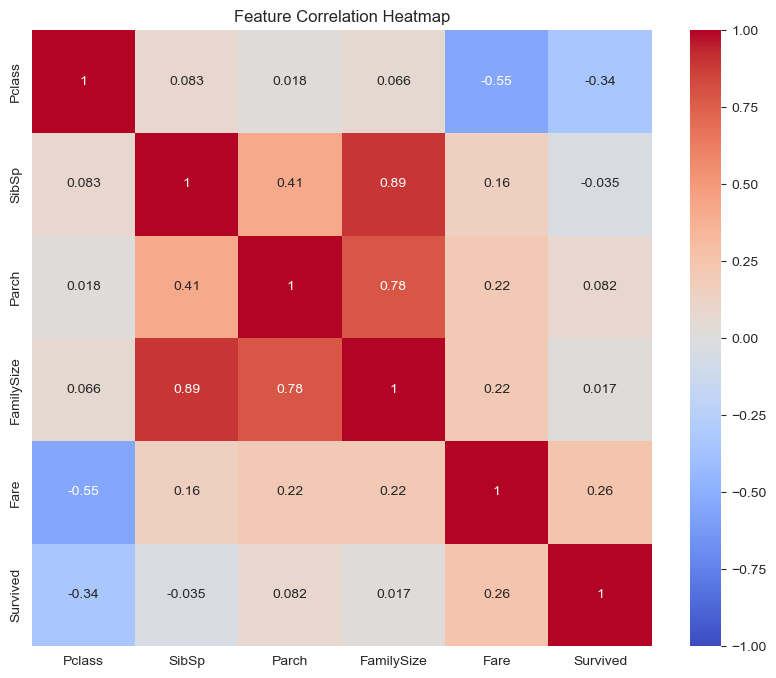

In [125]:
# 特徵相關性熱圖
plt.figure(figsize=(10, 8))
features = ["Pclass", "SibSp", "Parch", "FamilySize", "Fare", "Survived"]
corr_matrix = train_data[features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap')
plt.savefig('feature_correlation_heatmap.png')
plt.show()

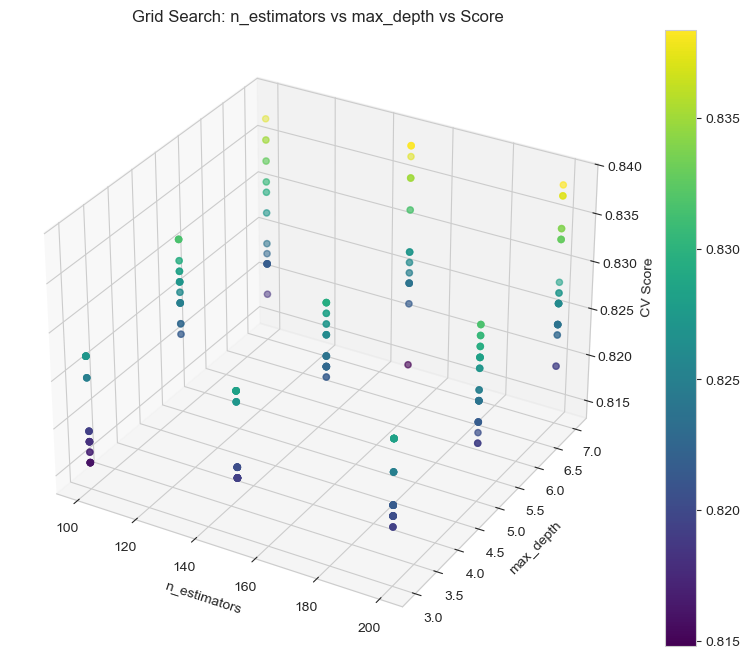

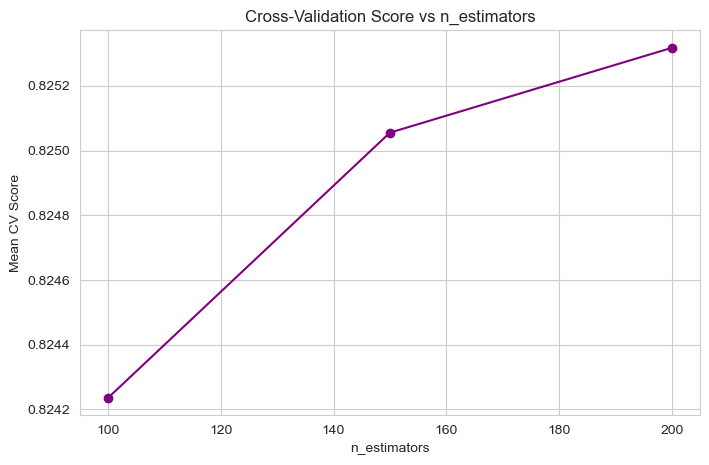

In [128]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 假設 grid_search 結果已生成
# 提取部分超參數結果作為範例
results = grid_search.cv_results_
n_estimators = results['param_n_estimators']
max_depth = results['param_max_depth']
scores = results['mean_test_score']

# 3D 散點圖
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(n_estimators, max_depth, scores, c=scores, cmap='viridis')
ax.set_xlabel('n_estimators')
ax.set_ylabel('max_depth')
ax.set_zlabel('CV Score')
plt.title('Grid Search: n_estimators vs max_depth vs Score')
plt.colorbar(scatter)
plt.savefig('grid_search_3d.png')
plt.show()

# 交叉驗證分數折線圖（假設按 n_estimators 變化）
plt.figure(figsize=(8, 5))
unique_n = np.unique(n_estimators)
mean_scores = [np.mean(scores[n_estimators == n]) for n in unique_n]
plt.plot(unique_n, mean_scores, marker='o', color='purple')
plt.title('Cross-Validation Score vs n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Mean CV Score')
plt.savefig('cv_score_line.png')
plt.show()

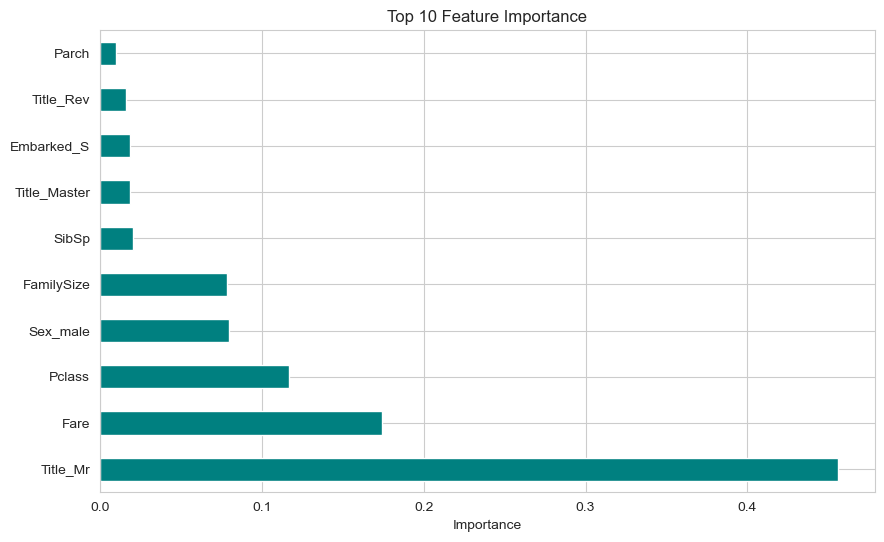

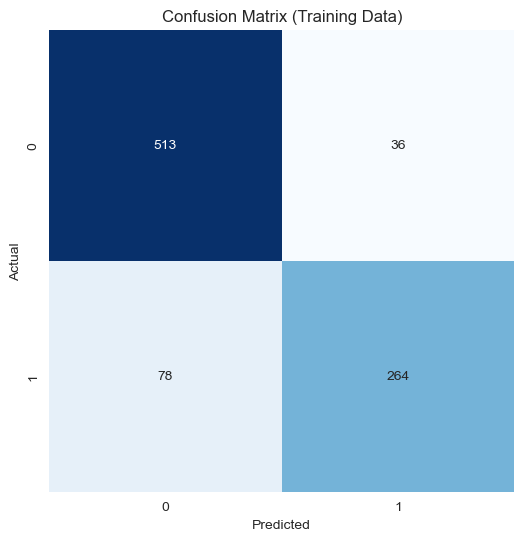

In [131]:
from sklearn.metrics import confusion_matrix

# 特徵重要性柱狀圖
plt.figure(figsize=(10, 6))
feat_importance = pd.Series(best_rf_model.feature_importances_, index=X.columns)
feat_importance.nlargest(10).plot(kind='barh', color='teal')
plt.title('Top 10 Feature Importance')
plt.xlabel('Importance')
plt.savefig('feature_importance_bar.png')
plt.show()

# 混淆矩陣（假設使用訓練集預測作為範例）
y_pred_train = best_rf_model.predict(X)
cm = confusion_matrix(y, y_pred_train)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Training Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png')
plt.show()

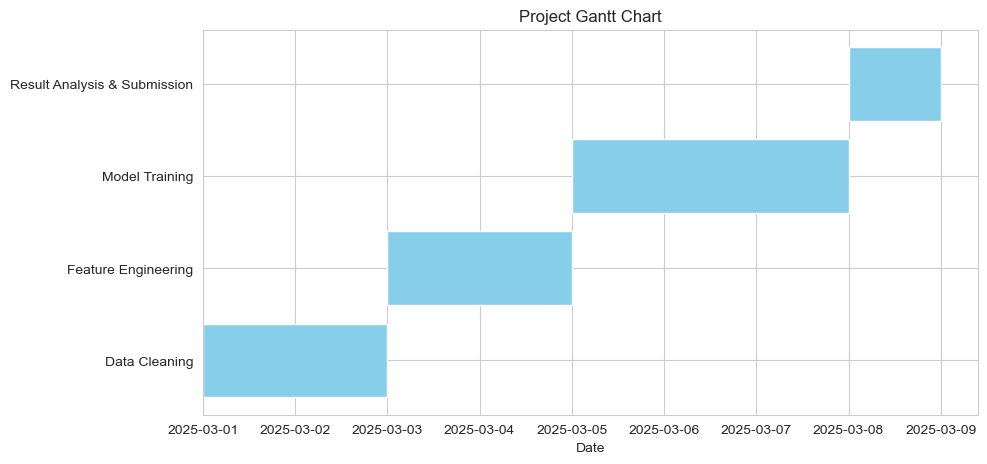

In [133]:
import matplotlib.dates as mdates

# 甘特圖
tasks = ['Data Cleaning', 'Feature Engineering', 'Model Training', 'Result Analysis & Submission']
start_dates = ['2025-03-01', '2025-03-03', '2025-03-05', '2025-03-08']
durations = [2, 2, 3, 1]  # 天數

fig, ax = plt.subplots(figsize=(10, 5))
for i, task in enumerate(tasks):
    ax.barh(task, durations[i], left=pd.to_datetime(start_dates[i]), color='skyblue')
ax.set_xlabel('Date')
ax.set_title('Project Gantt Chart')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.savefig('gantt_chart.png')
plt.show()

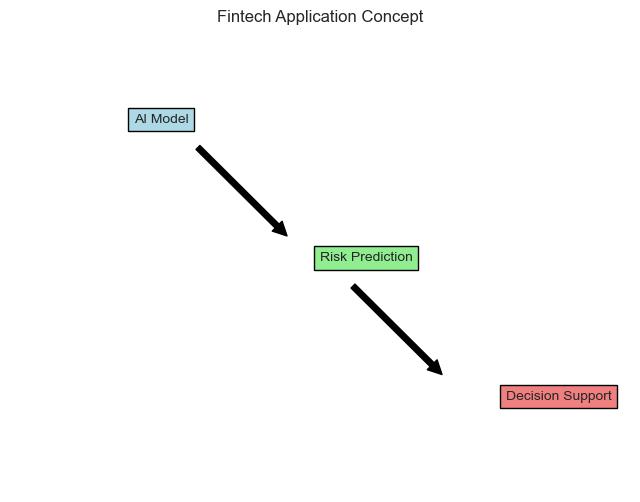

In [134]:
# 簡單的概念圖（流程圖）
from matplotlib.patches import FancyArrowPatch

fig, ax = plt.subplots(figsize=(8, 6))
ax.text(0.2, 0.8, 'AI Model', bbox=dict(facecolor='lightblue', edgecolor='black'))
ax.text(0.5, 0.5, 'Risk Prediction', bbox=dict(facecolor='lightgreen', edgecolor='black'))
ax.text(0.8, 0.2, 'Decision Support', bbox=dict(facecolor='lightcoral', edgecolor='black'))
arrow1 = FancyArrowPatch((0.3, 0.75), (0.45, 0.55), mutation_scale=20, color='black')
arrow2 = FancyArrowPatch((0.55, 0.45), (0.7, 0.25), mutation_scale=20, color='black')
ax.add_patch(arrow1)
ax.add_patch(arrow2)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')
plt.title('Fintech Application Concept')
plt.savefig('fintech_concept.png')
plt.show()